In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline


In [2]:
train_df =  pd.read_excel('Data_Train.xlsx')
test_df=pd.read_excel('Test_set.xlsx')

In [3]:
train_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [108]:
train_df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [109]:
test_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [110]:
test_df.describe()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
count,2671,2671,2671,2671,2671,2671,2671,2671,2671,2671
unique,11,44,5,6,100,199,704,320,5,6
top,Jet Airways,9/05/2019,Delhi,Cochin,DEL → BOM → COK,10:00,19:00,2h 50m,1 stop,No info
freq,897,144,1145,1145,624,62,113,122,1431,2148


In [4]:
big_df = train_df.append(test_df)

c:\users\snehanshu17\anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
big_df['Date'] = big_df['Date_of_Journey'].str.split('/').str[0]
big_df['Month'] = big_df['Date_of_Journey'].str.split('/').str[1]
big_df['Year'] = big_df['Date_of_Journey'].str.split('/').str[2]

In [6]:
big_df['Date'] = big_df['Date'].astype(int)
big_df['Month'] = big_df['Month'].astype(int)
big_df['Year'] = big_df['Year'].astype(int)

In [7]:
big_df=big_df.drop(['Date_of_Journey'], axis=1)

In [8]:
big_df['Arrival_Time'] = big_df['Arrival_Time'] .str.split(' ').str[0]

In [9]:
big_df['Total_Stops']=big_df['Total_Stops'].fillna('1 stop')

In [10]:
big_df['Total_Stops']=big_df['Total_Stops'].replace('non-stop','0 stop')

In [11]:
big_df['Stop'] = big_df['Total_Stops'].str.split(' ').str[0]

In [12]:
big_df['Stop'] = big_df['Stop'].astype(int)

In [13]:
big_df=big_df.drop(['Total_Stops'], axis=1)

In [14]:
big_df['Arrival_Hour'] = big_df['Arrival_Time'] .str.split(':').str[0]
big_df['Arrival_Minute'] = big_df['Arrival_Time'] .str.split(':').str[1]

big_df['Arrival_Hour'] = big_df['Arrival_Hour'].astype(int)
big_df['Arrival_Minute'] = big_df['Arrival_Minute'].astype(int)
big_df=big_df.drop(['Arrival_Time'], axis=1)

In [15]:
big_df['Dep_Hour'] = big_df['Dep_Time'] .str.split(':').str[0]
big_df['Dep_Minute'] = big_df['Dep_Time'] .str.split(':').str[1]
big_df['Dep_Hour'] = big_df['Dep_Hour'].astype(int)
big_df['Dep_Minute'] = big_df['Dep_Minute'].astype(int)
big_df=big_df.drop(['Dep_Time'], axis=1)

In [16]:
big_df['Route_1'] = big_df['Route'] .str.split('→ ').str[0]
big_df['Route_2'] = big_df['Route'] .str.split('→ ').str[1]
big_df['Route_3'] = big_df['Route'] .str.split('→ ').str[2]
big_df['Route_4'] = big_df['Route'] .str.split('→ ').str[3]
big_df['Route_5'] = big_df['Route'] .str.split('→ ').str[4]

In [17]:
big_df['Price'].fillna((big_df['Price'].mean()), inplace=True)

In [18]:
big_df.describe()

,Price,Date,Month,Year,Stop,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute
count,13354.000000,13354.000000,13354.000000,13354.0,13354.000000,13354.000000,13354.000000,13354.000000,13354.000000
mean,9087.064121,13.389846,4.710574,2019.0,0.826045,13.396061,24.664146,12.513254,24.507264
std,4124.447805,8.439060,1.165622,0.0,0.674608,6.896145,16.559723,5.736273,18.832385
min,1759.000000,1.000000,3.000000,2019.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6135.250000,6.000000,3.000000,2019.0,0.000000,8.000000,10.000000,8.000000,5.000000
50%,9087.064121,12.000000,5.000000,2019.0,1.000000,14.000000,25.000000,11.000000,25.000000
75%,11087.000000,21.000000,6.000000,2019.0,1.000000,19.000000,35.000000,18.000000,40.000000
max,79512.000000,27.000000,6.000000,2019.0,4.000000,23.000000,55.000000,23.000000,55.000000


In [19]:
big_df['Route_1'].fillna("None",inplace = True)
big_df['Route_2'].fillna("None",inplace = True)
big_df['Route_3'].fillna("None",inplace = True)
big_df['Route_4'].fillna("None",inplace = True)
big_df['Route_5'].fillna("None",inplace = True)

In [20]:
big_df=big_df.drop(['Route'], axis=1)
big_df=big_df.drop(['Duration'], axis=1)

In [21]:
from sklearn.preprocessing import LabelEncoder

lb_encode = LabelEncoder()
big_df["Additional_Info"] = lb_encode.fit_transform(big_df["Additional_Info"])
big_df["Airline"] = lb_encode.fit_transform(big_df["Airline"])
big_df["Destination"] = lb_encode.fit_transform(big_df["Destination"])
big_df["Source"] = lb_encode.fit_transform(big_df["Source"])
big_df['Route_1']= lb_encode.fit_transform(big_df["Route_1"])
big_df['Route_2']= lb_encode.fit_transform(big_df["Route_2"])
big_df['Route_3']= lb_encode.fit_transform(big_df["Route_3"])
big_df['Route_4']= lb_encode.fit_transform(big_df["Route_4"])
big_df['Route_5']= lb_encode.fit_transform(big_df["Route_5"])

In [22]:
big_df.head()

,Additional_Info,Airline,Destination,Price,Source,Date,Month,Year,Stop,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute,Route_1,Route_2,Route_3,Route_4,Route_5
0,8,3,5,3897.0,0,24,3,2019,0,1,10,22,20,0,13,24,12,4
1,8,1,0,7662.0,3,1,5,2019,2,13,15,5,50,2,25,1,3,4
2,8,4,1,13882.0,2,9,6,2019,2,4,25,9,25,3,32,4,5,4
3,8,3,0,6218.0,3,12,5,2019,1,23,30,18,5,2,34,3,12,4
4,8,3,5,13302.0,0,1,3,2019,1,21,35,16,50,0,34,8,12,4


In [23]:
#missing value validation
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns  

In [24]:
missing_values_table(big_df)

Your selected dataframe has 18 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [25]:
big_df.describe()

,Additional_Info,Airline,Destination,Price,Source,Date,Month,Year,Stop,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute,Route_1,Route_2,Route_3,Route_4,Route_5
count,13354.000000,13354.000000,13354.000000,13354.000000,13354.000000,13354.000000,13354.000000,13354.0,13354.000000,13354.000000,13354.000000,13354.000000,13354.000000,13354.000000,13354.000000,13354.000000,13354.000000,13354.000000
mean,7.407743,3.977086,1.435450,9087.064121,1.954096,13.389846,4.710574,2019.0,0.826045,13.396061,24.664146,12.513254,24.507264,2.015651,11.915681,11.571664,10.938071,3.987345
std,1.198393,2.363997,1.473368,4124.447805,1.178607,8.439060,1.165622,0.0,0.674608,6.896145,16.559723,5.736273,18.832385,1.205399,8.035899,9.035316,2.602641,0.203479
min,0.000000,0.000000,0.000000,1759.000000,0.000000,1.000000,3.000000,2019.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,3.000000,0.000000,6135.250000,2.000000,6.000000,3.000000,2019.0,0.000000,8.000000,10.000000,8.000000,5.000000,1.000000,7.000000,4.000000,12.000000,4.000000
50%,8.000000,4.000000,1.000000,9087.064121,2.000000,12.000000,5.000000,2019.0,1.000000,14.000000,25.000000,11.000000,25.000000,2.000000,7.000000,6.000000,12.000000,4.000000
75%,8.000000,4.000000,2.000000,11087.000000,3.000000,21.000000,6.000000,2019.0,1.000000,19.000000,35.000000,18.000000,40.000000,3.000000,14.000000,24.000000,12.000000,4.000000
max,9.000000,11.000000,5.000000,79512.000000,4.000000,27.000000,6.000000,2019.0,4.000000,23.000000,55.000000,23.000000,55.000000,5.000000,45.000000,30.000000,13.000000,5.000000


In [27]:
df_train = big_df[0:10683]
df_test = big_df[10683:]
df_test = df_test.drop(['Price'], axis =1)

In [28]:
df_test.describe()

,Additional_Info,Airline,Destination,Source,Date,Month,Year,Stop,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute,Route_1,Route_2,Route_3,Route_4,Route_5
count,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.0,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000
mean,7.466492,4.021715,1.432797,1.961438,12.915762,4.718458,2019.0,0.833396,13.585174,24.558218,12.603519,24.891426,1.999626,11.917259,11.441033,10.933733,3.986896
std,1.131230,2.410708,1.467971,1.184328,8.260824,1.170851,0.0,0.672315,7.040396,16.775436,5.686673,19.086522,1.200967,7.936846,8.982139,2.617234,0.214233
min,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,2019.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,8.000000,3.000000,0.000000,2.000000,6.000000,3.000000,2019.0,0.000000,8.000000,10.000000,8.000000,5.000000,1.000000,7.000000,4.000000,12.000000,4.000000
50%,8.000000,4.000000,1.000000,2.000000,12.000000,5.000000,2019.0,1.000000,15.000000,25.000000,12.000000,25.000000,2.000000,7.000000,6.000000,12.000000,4.000000
75%,8.000000,6.000000,2.000000,3.000000,21.000000,6.000000,2019.0,1.000000,19.000000,35.000000,18.000000,45.000000,3.000000,14.000000,24.000000,12.000000,4.000000
max,8.000000,11.000000,5.000000,4.000000,27.000000,6.000000,2019.0,4.000000,23.000000,55.000000,23.000000,55.000000,4.000000,44.000000,30.000000,13.000000,5.000000


In [29]:
X = df_train.drop(['Price'], axis=1)
y = df_train.Price

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [31]:
#Build our model method
lm = LinearRegression()

In [32]:
#Build our cross validation method
kfolds = KFold(n_splits=10, shuffle=True, random_state=23)

In [33]:
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)

In [34]:
#second scoring metric
def cv_rmsle(model):
    rmsle = np.sqrt(np.log(-cross_val_score(model, X, y,
                                           scoring = 'neg_mean_squared_error',
                                           cv=kfolds)))
    return(rmsle)

In [54]:
benchmark_model = make_pipeline(RobustScaler(),
                                lm).fit(X=X_train, y=y_train)
cv_rmse(benchmark_model).mean()

3273.0059400484165

In [59]:
from sklearn.linear_model import RidgeCV

def ridge_selector(k):
    ridge_model = make_pipeline(RobustScaler(),
                                RidgeCV(alphas = [k],
                                        cv=kfolds)).fit(X_train, y_train)
    
    ridge_rmse = cv_rmse(ridge_model).mean()
    return(ridge_rmse)

In [60]:
r_alphas = [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]

ridge_scores = []
for alpha in r_alphas:
    score = ridge_selector(alpha)
    ridge_scores.append(score)

,RMSE
0.0001,3273.005939
0.0003,3273.005937
0.0005,3273.005936
0.0007,3273.005934
0.0009,3273.005932
0.0100,3273.005851
0.0500,3273.005495
0.1000,3273.005051
0.3000,3273.003292
1.0000,3272.997337


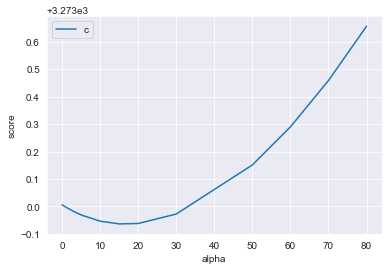

In [61]:
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.legend('center')
plt.xlabel('alpha')
plt.ylabel('score')

ridge_score_table = pd.DataFrame(ridge_scores, r_alphas, columns=['RMSE'])
ridge_score_table

In [58]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]

ridge_model2 = make_pipeline(RobustScaler(),
                            RidgeCV(alphas = alphas_alt,
                                    cv=kfolds)).fit(X_train, y_train)

cv_rmse(ridge_model2).mean()

3272.9403631474406

In [62]:
from sklearn.linear_model import LassoCV


alphas = [0.00005, 0.0001, 0.0003, 0.0005, 0.0007, 
          0.0009, 0.01]
alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
           0.0006, 0.0007, 0.0008]


lasso_model2 = make_pipeline(RobustScaler(),
                             LassoCV(max_iter=1e7,
                                    alphas = alphas2,
                                    random_state = 42)).fit(X_train, y_train)

c:\users\snehanshu17\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


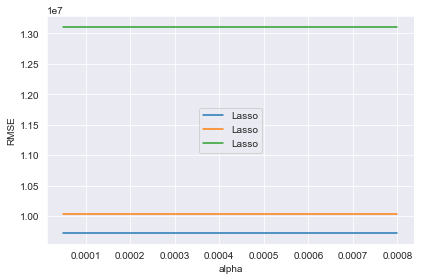

In [63]:
scores = lasso_model2.steps[1][1].mse_path_

plt.plot(alphas2, scores, label='Lasso')
plt.legend(loc='center')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

In [64]:
cv_rmse(lasso_model2).mean()

c:\users\snehanshu17\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\snehanshu17\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\snehanshu17\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\snehanshu17\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of 

3273.005929514414

In [43]:
coeffs = pd.DataFrame(list(zip(X.columns, lasso_model2.steps[1][1].coef_)), columns=['Predictors', 'Coefficients'])

In [65]:
used_coeffs = coeffs[coeffs['Coefficients'] != 0].sort_values(by='Coefficients', ascending=False)
print(used_coeffs.shape)
print(used_coeffs)

(16, 2)
         Predictors  Coefficients
7              Stop   3757.470403
2       Destination    729.086176
16          Route_5    474.348876
10         Dep_Hour    261.079006
0   Additional_Info    151.217275
1           Airline    142.081667
15          Route_4     60.807728
9    Arrival_Minute    -41.315753
3            Source   -125.206621
8      Arrival_Hour   -125.309615
11       Dep_Minute   -130.156193
13          Route_2   -693.087463
12          Route_1   -714.092858
5             Month  -1033.043742
4              Date  -1132.888312
14          Route_3  -2812.955977


In [66]:
used_coeffs_values = X[used_coeffs['Predictors']]
used_coeffs_values.shape

(10683, 16)

In [67]:
overfit_test2 = []
for i in used_coeffs_values.columns:
    counts2 = used_coeffs_values[i].value_counts()
    zeros2 = counts2.iloc[0]
    if zeros2 / len(used_coeffs_values) * 100 > 99.5:
        overfit_test2.append(i)
        
overfit_test2

['Route_5']

In [69]:
from sklearn.linear_model import ElasticNetCV

e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elastic_cv = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

elastic_model3 = elastic_cv.fit(X_train, y_train)

In [70]:
cv_rmse(elastic_model3).mean()

3272.9944999052564

In [71]:
from sklearn.model_selection import GridSearchCV
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
%matplotlib inline
import xgboost as xgb
from xgboost import XGBRegressor

In [72]:
def modelfit(alg, dtrain, target, useTrainCV=True, 
             cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, 
                              label=y.values)
        
        print("\nGetting Cross-validation result..")
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,metrics='rmse', 
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval = True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    print("\nFitting algorithm to data...")
    alg.fit(dtrain, target, eval_metric='rmse')
        
    #Predict training set:
    print("\nPredicting from training data...")
    dtrain_predictions = alg.predict(dtrain)
        
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(mean_squared_error(target.values,
                                             dtrain_predictions)))

In [73]:
xgb3 = XGBRegressor(learning_rate =0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006)

xgb_fit = xgb3.fit(X_train, y_train)

In [74]:
from sklearn import svm
svr_opt = svm.SVR(C = 100000, gamma = 1e-08)

svr_fit = svr_opt.fit(X_train, y_train)

In [75]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [76]:
cv_rmse(lgbm_model).mean()

1993.66523541231

In [77]:
lgbm_fit = lgbm_model.fit(X_train, y_train)

In [78]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url = "http://i.imgur.com/QBuDOjs.jpg")

In [80]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

#setup models
ridge = make_pipeline(RobustScaler(), 
                      RidgeCV(alphas = alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = alphas2,
                              random_state = 42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

lightgbm = make_pipeline(RobustScaler(),
                        LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, 
                                      min_sum_hessian_in_leaf = 11))


xgboost = make_pipeline(RobustScaler(),
                        XGBRegressor(learning_rate =0.01, n_estimators=3460, 
                                     max_depth=3,min_child_weight=0 ,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective= 'reg:linear',nthread=4,
                                     scale_pos_weight=1,seed=27, 
                                     reg_alpha=0.00006))


#stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, 
                                            xgboost, lightgbm), 
                               meta_regressor=xgboost,
                               use_features_in_secondary=True)



#prepare dataframes
stackX = np.array(X_train)
stacky = np.array(y_train)


In [81]:
stack_gen_model = stack_gen.fit(stackX, stacky)

In [91]:
em_preds = elastic_model3.predict(X_test)
lasso_preds = lasso_model2.predict(X_test)
ridge_preds = ridge_model2.predict(X_test)
stack_gen_preds = stack_gen_model.predict(X_test)
xgb_preds = xgb_fit.predict(X_test)
svr_preds = svr_fit.predict(X_test)
lgbm_preds = lgbm_fit.predict(X_test)

In [107]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = np.sqrt(mean_squared_error(y_test, stack_gen_preds))
print("RMSE: %f" % (rmse))

RMSE: 1547.606064


In [92]:
stack_preds = ((0.2*em_preds) + (0.1*lasso_preds) + (0.1*ridge_preds) + 
               (0.2*xgb_preds) + (0.1*lgbm_preds) + (0.3*stack_gen_preds))

In [104]:
df_test_xgb = df_test[['Additional_Info', 'Airline', 'Destination', 'Source', 'Date', 'Month',
       'Year', 'Stop', 'Arrival_Hour', 'Arrival_Minute', 'Dep_Hour',
       'Dep_Minute', 'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5']]
preds_1 = stack_gen_model.predict(df_test_xgb)
df_test_xgb['Price'] = preds_1
df_test_xgb.to_csv('flight_price_3.csv')

In [97]:
dataframe=pd.DataFrame(stack_preds, columns=['Price']) 

In [103]:
dataframe.to_csv('flight_price_4.csv')

In [64]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.4603, learning_rate = 0.05, min_child_weight=1.5,
                          max_depth = 4, n_estimators =7200)

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

In [99]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 1555.157426


In [100]:
df_test.columns

Index(['Additional_Info', 'Airline', 'Destination', 'Source', 'Date', 'Month',
       'Year', 'Stop', 'Arrival_Hour', 'Arrival_Minute', 'Dep_Hour',
       'Dep_Minute', 'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5'],
      dtype='object')

In [102]:
df_test_xgb = df_test[['Additional_Info', 'Airline', 'Destination', 'Source', 'Date', 'Month',
       'Year', 'Stop', 'Arrival_Hour', 'Arrival_Minute', 'Dep_Hour',
       'Dep_Minute', 'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5']]
preds_1 = xg_reg.predict(df_test_xgb)
df_test_xgb['Price'] = preds_1
df_test_xgb.to_csv('flight_price_3.csv')